# B站：神奇的布欧
# 微信：l1243278923

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchvision import transforms
from torchvision.models import get_model
from torchvision.transforms import v2
from torchvision import models
import PIL.Image
import matplotlib.pyplot as plt

# 0. 判断GPU是否可用

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. 数据预处理

In [3]:
dataPath = "./MNIST"
train_data = torchvision.datasets.MNIST(
    root=dataPath,
    train=True,
    transform=v2.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    ]),
    download=False
)
test_data = torchvision.datasets.MNIST(
    root=dataPath,
    train=False,
    transform=v2.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    ]),
    download=False
)

In [4]:
# 数据集加载器
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True,
    drop_last=True
)
test_loader = Data.DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=True,
    drop_last=True
)

In [5]:
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break
print(b_x.shape)
print(b_y.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


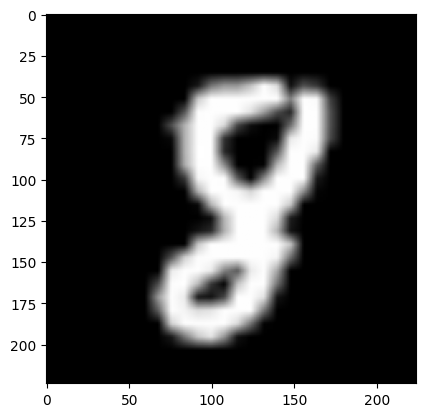

In [6]:
plt.imshow(b_x[0].permute(1, 2, 0).numpy())

# 2. 模型搭建

In [7]:
# 导入vgg16
vgg16 = models.vgg16(pretrained=True)
vgg16 = get_model("vgg16", weights="DEFAULT")

D:\software_code\Anaconda\envs\pytorchpy39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\software_code\Anaconda\envs\pytorchpy39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
vgg = vgg16.features
for param in vgg.parameters():
    param.requires_grad_(False)

In [10]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.vgg = vgg
        self.classifier = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.vgg(x)
        x = x.flatten(start_dim=1)
        output = self.classifier(x)
        return output

In [12]:
model = Model().to(device)

In [13]:
model

Model(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

# 3. 训练

In [14]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fun = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(2):
        for index, (x, y) in enumerate(train_loader):
            out = model(x.to(device))
            loss = loss_fun(out.to("cpu"), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if index % 10 == 0:
                acc = (out.to("cpu").argmax(dim=1) == y).sum().item() / len(y)
                print(f"{epoch + 1}、序号：{index:<5}, 损失：{loss.item():<20}、准确率：{acc}")
    torch.save(model, "./10迁移学习数字计算器.model")

In [15]:
train()

1、序号：0    , 损失：2.3027172088623047  、准确率：0.078125
1、序号：10   , 损失：1.789686918258667   、准确率：0.8125
1、序号：20   , 损失：1.6416021585464478  、准确率：0.859375
1、序号：30   , 损失：1.6228677034378052  、准确率：0.859375
1、序号：40   , 损失：1.5644347667694092  、准确率：0.90625
1、序号：50   , 损失：1.5396987199783325  、准确率：0.9375
1、序号：60   , 损失：1.5152243375778198  、准确率：0.953125
1、序号：70   , 损失：1.5193076133728027  、准确率：0.9375
1、序号：80   , 损失：1.5121451616287231  、准确率：0.953125
1、序号：90   , 损失：1.500710129737854   、准确率：0.96875
1、序号：100  , 损失：1.511029839515686   、准确率：0.953125
1、序号：110  , 损失：1.5075316429138184  、准确率：0.953125
1、序号：120  , 损失：1.502569556236267   、准确率：0.953125
1、序号：130  , 损失：1.500711441040039   、准确率：0.953125
1、序号：140  , 损失：1.5560657978057861  、准确率：0.90625
1、序号：150  , 损失：1.505528450012207   、准确率：0.953125
1、序号：160  , 损失：1.5003224611282349  、准确率：0.96875
1、序号：170  , 损失：1.5524389743804932  、准确率：0.90625
1、序号：180  , 损失：1.50752592086792    、准确率：0.953125
1、序号：190  , 损失：1.5217630863189697  、准确率：0.9375
1、序号：200  , 损失：1.5247883796691895

# 4. 测试

In [18]:
@torch.no_grad()
def test():
    model = torch.load("./10迁移学习数字计算器.model").to("cpu")
    model.eval()
    x, y = next(iter(test_loader))
    output = model(x)
    pre_lab = torch.argmax(output, 1)
    correct = torch.sum(pre_lab == y.data)
    total = len(y)
    print(pre_lab)
    print(y.data)
    print("准确率：" + str(correct / total))

In [19]:
test()

tensor([3, 7, 1, 7, 7, 3, 8, 7, 6, 4, 7, 5, 8, 7, 5, 8, 9, 8, 4, 0, 6, 8, 9, 4,
        7, 4, 0, 7, 3, 8, 0, 3, 7, 3, 7, 8, 9, 8, 6, 5, 1, 5, 0, 0, 0, 7, 2, 7,
        2, 7, 0, 3, 8, 2, 3, 8, 1, 5, 0, 4, 9, 2, 9, 8])
tensor([3, 7, 1, 7, 7, 3, 8, 7, 6, 4, 7, 5, 8, 7, 5, 8, 9, 8, 4, 0, 6, 8, 9, 4,
        8, 4, 0, 7, 3, 6, 0, 3, 7, 3, 7, 8, 9, 8, 6, 5, 1, 5, 0, 0, 0, 7, 2, 7,
        2, 7, 0, 3, 8, 2, 3, 8, 1, 5, 0, 4, 9, 2, 9, 8])
准确率：tensor(0.9688)


# 5. 可视化结果

In [20]:
x, y = next(iter(test_loader))
model = torch.load("./10迁移学习数字计算器.model").to("cpu")
out = model(x).argmax(1)

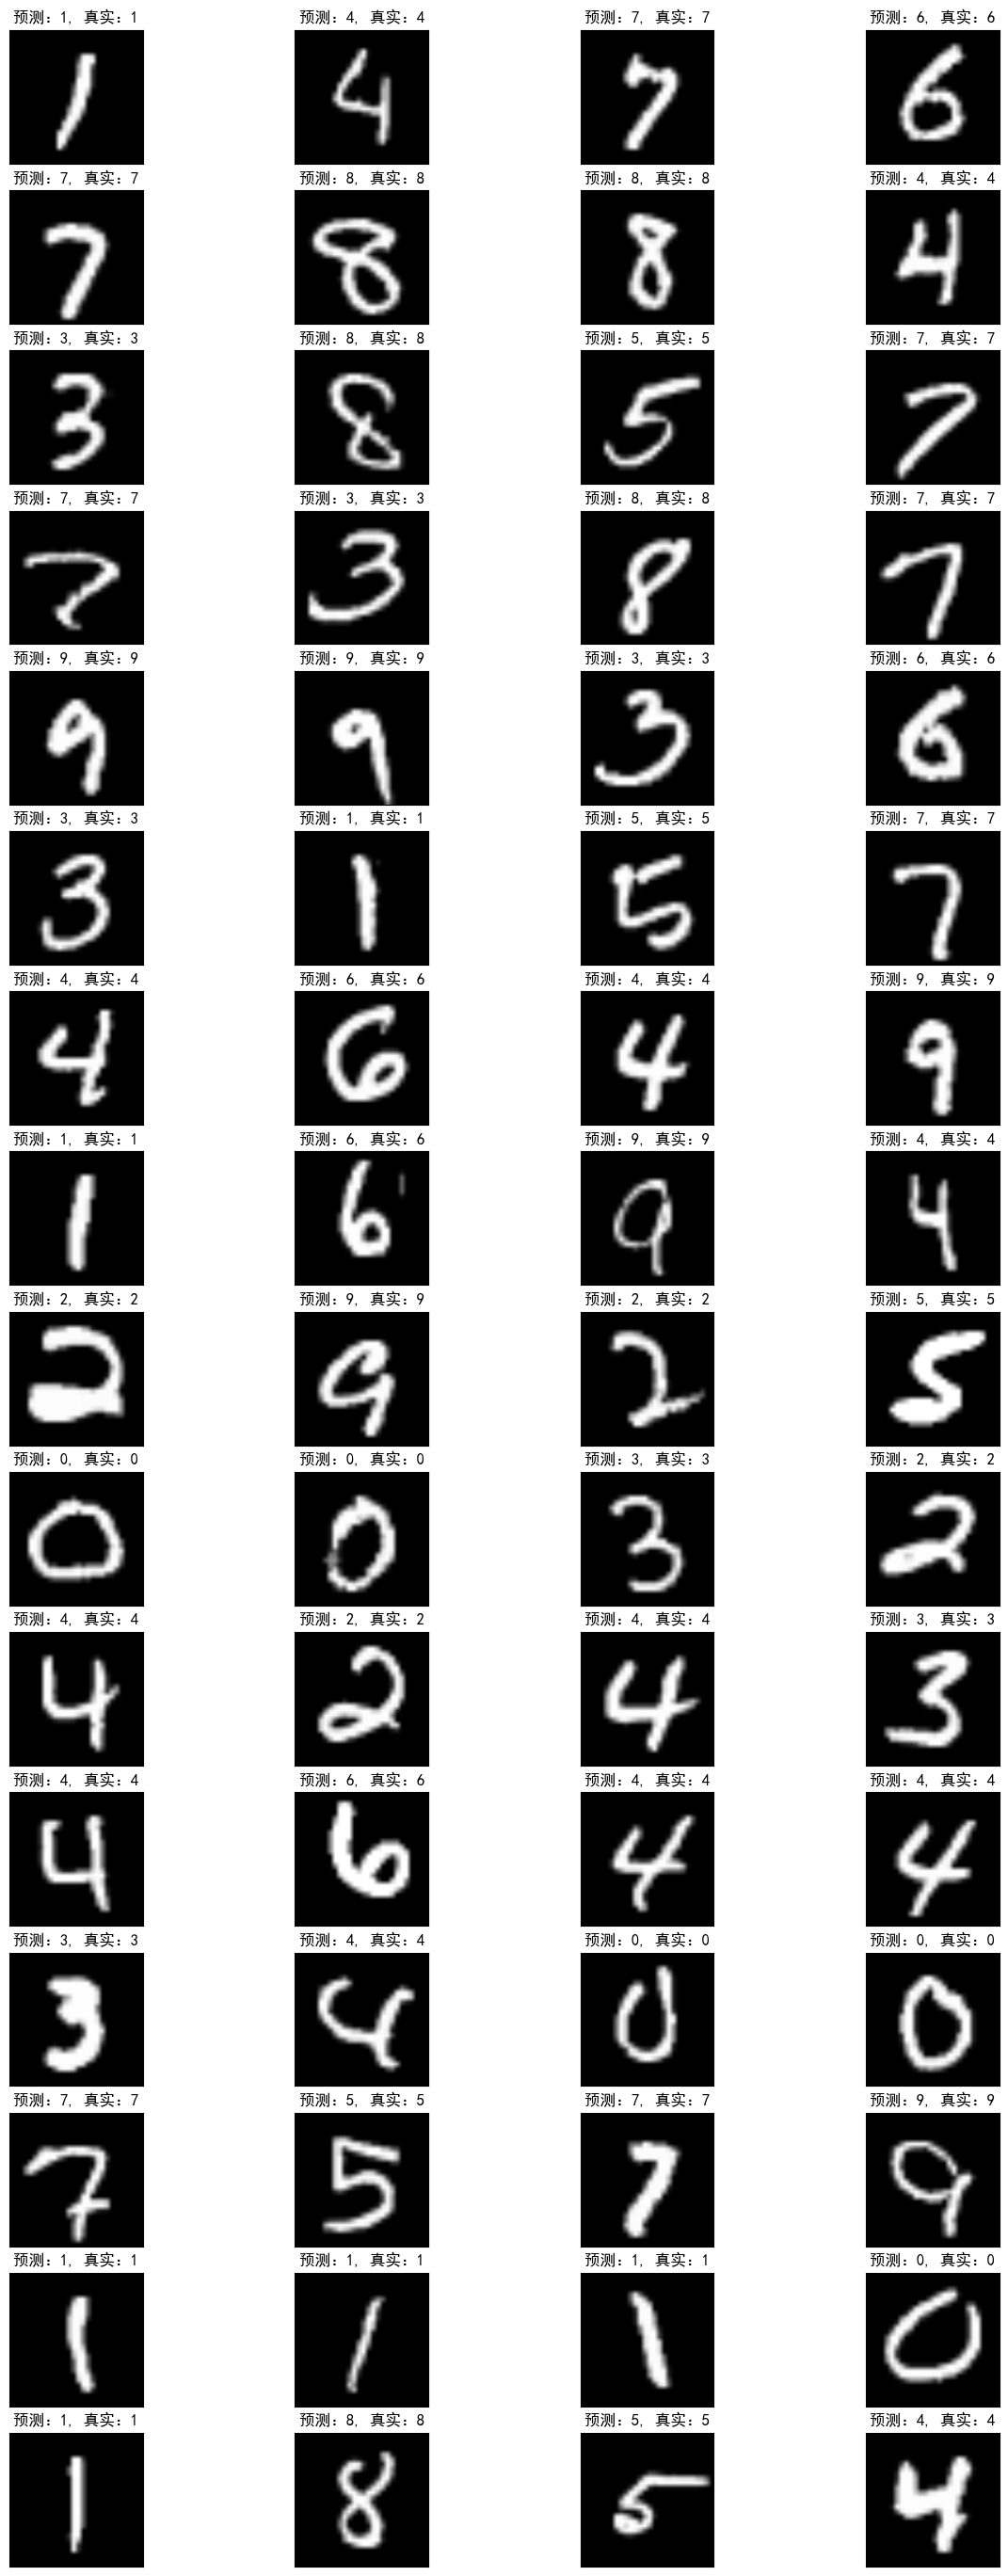

In [21]:
plt.rcParams['font.sans-serif'] = ['SimHei']
title = [f"预测：{pre}, 真实：{label}" for pre, label in zip(out.tolist(), y.tolist())]
images = [img for img in x.permute(0, 2, 3, 1).numpy()]
plt.figure(figsize=(15, 35))
for i in range(64):
    plt.subplot(16, 4, i + 1)
    plt.imshow(images[i])
    plt.title(title[i])
    plt.xticks([]), plt.yticks([])
plt.show()

# 6. 计算部分

In [51]:
@torch.no_grad()
def compute(num1Path, num2Path, sign):
    model = torch.load("./10迁移学习数字计算器.model").to("cpu")
    number1 = PIL.Image.open(num1Path)
    number2 = PIL.Image.open(num2Path)
    transforms = v2.Compose([
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.ToTensor(),
    ])
    number1 = transforms(number1)
    number2 = transforms(number2)
    number1 = torch.unsqueeze(number1, dim=0)
    number2 = torch.unsqueeze(number2, dim=0)
    out1 = model(number1).argmax(dim=1).item()
    out2 = model(number2).argmax(dim=1).item()
    if sign == '+':
        print(f"{out1} + {out2} = {out1 + out2}")
    elif sign == '-':
        print(f"{out1} - {out2} = {out1 - out2}")
    elif sign == '*':
        print(f"{out1} * {out2} = {out1 * out2}")
    elif sign == '/':
        print(f"{out1} / {out2} = {out1 / out2}")

In [58]:
num1Path = "./7.jpg"
num2Path = "./4.jpg"
sign = '/'

In [59]:
compute(num1Path, num2Path, sign)

1 / 4 = 0.25
